In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle


In [2]:
csv_path = '/content/Maternal Health Risk Data Set.csv'
df = pd.read_csv(csv_path)
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


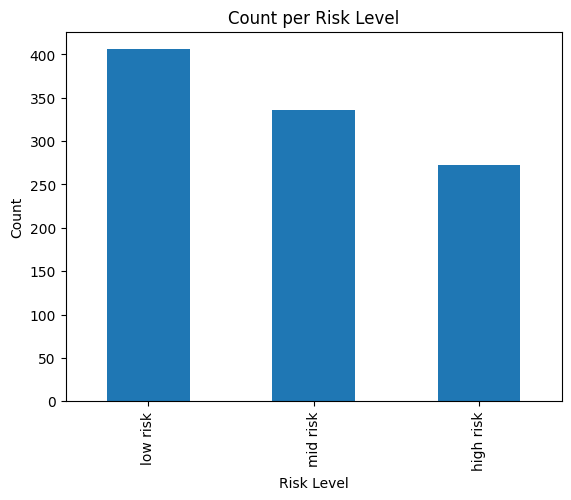

In [3]:
distribution = df['RiskLevel'].value_counts()
print(distribution)

distribution.plot(kind='bar')
plt.title('Count per Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.show()

In [5]:
label_map = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
df['RiskClass'] = df['RiskLevel'].map(label_map)

# Select features and target
target_col = 'RiskClass'
feature_cols = ['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
X = df[feature_cols]
y = df[target_col]



In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")


Train shape: (811, 5), Validation shape: (203, 5)


In [7]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    ))
])

# Fit on training data
pipeline.fit(X_train, y_train)

# Calibrate probabilities
calibrated = CalibratedClassifierCV(pipeline, method='isotonic', cv=5)
calibrated.fit(X_train, y_train)


CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('clf',
                                                  RandomForestClassifier(class_weight='balanced',
                                                                         n_estimators=200,
                                                                         random_state=42))]),
                       method='isotonic')

              precision    recall  f1-score   support

    Low Risk       0.86      0.83      0.84        81
 Medium Risk       0.82      0.79      0.80        67
   High Risk       0.88      0.96      0.92        55

    accuracy                           0.85       203
   macro avg       0.85      0.86      0.86       203
weighted avg       0.85      0.85      0.85       203



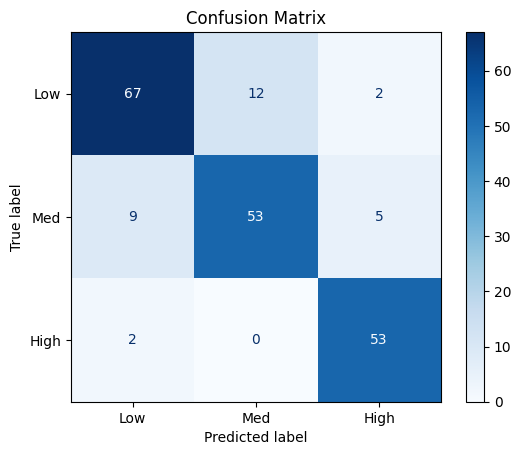

In [8]:
# 7) Predict and evaluate
y_pred = calibrated.predict(X_val)
print(classification_report(y_val, y_pred, target_names=['Low Risk','Medium Risk','High Risk']))

# Confusion matrix display
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low','Med','High'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [9]:
os.makedirs("Models", exist_ok=True)
with open("Models/finalized_maternal_model.sav", "wb") as f:
    pickle.dump(calibrated, f)
# Extract and save scaler separately
df_scaler = pipeline.named_steps['scaler']
with open("Models/scaler.sav", "wb") as f:
    pickle.dump(df_scaler, f)

print("Artifacts saved: model and scaler in Models/ folder.")


Artifacts saved: model and scaler in Models/ folder.
